In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('housing')

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  801.8134155273438
final loss:  2.9750988483428955


End2end test MAPE:  0.13030866
End2end test RMSE:  3.8439426
End2end test NLLK:  3.744492
End2end test CRPS:  tensor(2.0477)


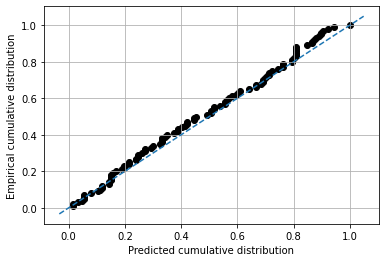

End2end test calibration error when step size is 0.001:  1.0367680776014114
End2end test calibration error when step size is 0.01:  0.10284328546233316
End2end test calibration error when step size is 0.1:  0.009700176366843043


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))